In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -r drive/My\ Drive/IVGS/RL/requirements.txt

     |████████████████████████████████| 102kB 3.4MB/s 
     |████████████████████████████████| 163kB 14.8MB/s 
     |████████████████████████████████| 163kB 15.4MB/s 
     |████████████████████████████████| 829kB 14.8MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 2.2MB 27.1MB/s 
     |████████████████████████████████| 1.5MB 43.7MB/s 
     |████████████████████████████████| 2.8MB 40.2MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 122kB 47.4MB/s 
     |████████████████████████████████| 778kB 48.2MB/s 
     |████████████████████████████████| 122kB 47.8MB/s 
     |████████████████████████████████| 1.0MB 44.1MB/s 
     |████████████████████████████████| 133kB 36.2MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 317kB 31.9MB/s 
   

In [ ]:
!unzip drive/My\ Drive/IVGS/RL/lib.zip

Archive:  drive/My Drive/IVGS/RL/lib.zip
   creating: bella/
  inflating: bella/config.yml        
 extracting: bella/__init__.py       
   creating: bella/test/
 extracting: bella/test/__init__.py  
  inflating: bella/test/api.py       
  inflating: bella/ciao.py           
  inflating: bella/config.py         
  inflating: bella/api.py            
 extracting: bella/.gitignore        
   creating: gemel/
 extracting: gemel/__init__.py       
  inflating: gemel/config.py         
   creating: gemel/vnet/
 extracting: gemel/vnet/__init__.py  
  inflating: gemel/vnet/vtn.py       
   creating: gemel/utils/
  inflating: gemel/utils/log.py      
 extracting: gemel/utils/__init__.py  
  inflating: gemel/utils/rest.py     
  inflating: gemel/utils/ssh.py      
  inflating: gemel/utils/shell.py    


In [ ]:
from bella.ciao import GemelEnv

import time
import os
import threading
import gym
import multiprocessing
import numpy as np
from queue import Queue
import argparse
import matplotlib.pyplot as plt
import enum
from itertools import permutations

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.backend import tensorflow_backend as K

from keras.layers import Dense, Flatten, Input, Add, Lambda, Embedding, Conv1D, MaxPooling1D
from keras.models import Model
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Activation, Reshape

from IPython.core.display import display, HTML, clear_output

In [ ]:
EPSILON = 0.1
EXPLORATION_DECAY = 0.99
GAMMA = 0.99

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total:
        print()

In [ ]:
class DQNAgent:
    class StateModel(enum.Enum):
        VN_ONLY = 1
        IDS = 2

    def __init__(self, env, max_eps, period=10,
                 state_mode=StateModel.IDS, model=None,
                 gamma=GAMMA, max_epsilon=EPSILON,
                 epsilon_decay=EXPLORATION_DECAY):

        self.env = env
        self.max_episodes = max_eps
        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.epsilon_dacay = epsilon_decay
        self.period = period
        self.state_mode = state_mode
        self.gamma = gamma
        self.model = model or self._create_model()

    def _create_model(self):
        """
        Builds a neural net model to digest the state
        """
        model = Sequential()
        model.add(Dense(
            5,
            # input_shape=,
            input_shape=(len(self.env._hosts_sorted_by_id),) \
                if self.state_mode == DQNAgent.StateModel.VN_ONLY \
                else self.env.observation_shape(),
            activation="relu"
        ))
        # model.add(Dense(20, activation="relu"))
        model.add(Dense(self.env.action_space.n, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        model.summary()
        return model

    def _to_feature_vector(self, state, ep):
        if self.state_mode == DQNAgent.StateModel.VN_ONLY:
            return state[0]
        elif self.state_mode == DQNAgent.StateModel.IDS:
            state_1 = np.array(list(permutations(state[1]))[100*ep])
            return np.concatenate((state[0], state_1.flatten()))
        else:
            raise Exception(f"state model {self.state_mode} unknown")

    def actionReverse(self, action, ep):
        idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        perm_idx = list(permutations(idx))[100*ep]
        host = action // 2
        security = action % 2
        action = (2*perm_idx[host] + security) if host < len(perm_idx) else action
        return action

    def train(self):

        histories = []

        # train for max_eps episodes
        for episode in range(1, self.max_episodes + 1):

            printProgressBar(episode, self.max_episodes)

            # start at random position
            _, terminal, step = self.env.reset(), False, 0

            time.sleep(self.period)

            state = self.env.state()

            # flatten state
            state = self._to_feature_vector(state, episode)

            history = []

            # iterate step-by-step
            while not terminal:

                step += 1

                # pick action based on policy
                action_raw, is_random = self.policy(state)
                action = self.actionReverse(action_raw, episode)

                print()
                print(f"Taking action {action} from {action_raw}")

                # run action and get reward
                state_next_raw, reward, terminal = self.env.step(action)

                # instead of using the immediate next state, wait for it to simmer
                if self.period > 0:
                    time.sleep(self.period)
                    state_next_raw = self.env.state()

                # flatten state
                state_next = self._to_feature_vector(state_next_raw, episode)

                print()
                print(f"Step {step} reward={reward} new_state={state_next_raw[0]}")

                # # this makes sense in an episodic environement
                # # where a terminal state means "losing"
                # if terminal:
                #    reward *= -1

                preds = self.model.predict([[state_next]])
                next_scores_prediction = preds[0]

                print(f"Predicted scores for each action in next step: {next_scores_prediction}")

                # compute target Q
                q_target = (reward + self.gamma * np.amax(next_scores_prediction)) if not terminal else reward

                # update model
                q_updated = self.model.predict([[state]])[0]
                q_updated[action_raw] = q_target
                self.model.fit([[state]], [[q_updated]], verbose=0)

                # update current state
                state = state_next

                # update history
                history.append({
                    "time": step,
                    "action": action_raw,
                    "reward": reward,
                    "state": state_next_raw[0].tolist(),
                    "random": is_random,
                    "prediction": preds,
                })

            histories.append(history)

            # apply exploration decay
            self.epsilon *= self.epsilon_dacay
            print(f"Epsilon reduced to {self.epsilon}")

        return histories

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            print("PERFORMING RANDOM ACTION")
            return np.random.randint(self.env.action_space.n), True
        else:
            expected_rewards = self.model.predict([[state]])[0]
            return np.argmax(expected_rewards), False

    def test(self):

        state, done = self.env.reset(), False
        total_reward = 0

        while not done:
            state = self._to_feature_vector(state, 0)
            exp_rew = self.model.predict([[state]])[0]
            action = np.argmax(exp_rew)
            new_state, reward, done = self.env.step(action)
            total_reward += reward
            self.env.render()
            time.sleep(0.05)
            state = new_state

        # self.env.close()
        print(f"Total reward: {total_reward}")

In [ ]:
def model_conv_15(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(3, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 187, 3)            12        
_________________________________________________________________
flatten_10 (Flatten)         (None, 561)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 19)                10678     
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 
Taking action 10

Step 1 reward=-1 new_state=[0 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [ 0.01859224 -0.02113799 -0.07403752  0.1726839

TypeError: ignored

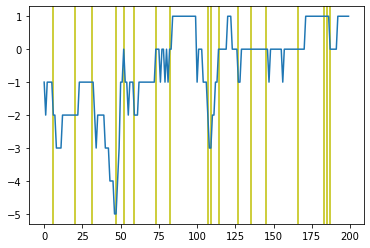

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=4, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_15(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_20(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(50, kernel_size=env.action_space.n, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 187, 32)           128       
_________________________________________________________________
flatten_12 (Flatten)         (None, 5984)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 19)                113715    
Total params: 113,843
Trainable params: 113,843
Non-trainable params: 0
_________________________________________________________________
 |████████████████------------------------------------------------------------------------------------| 16.7% 
Taking action 6

Step 1 reward=-1 new_state=[0 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [-0.08758324 -0.00368383  0.1580424  -0.098211

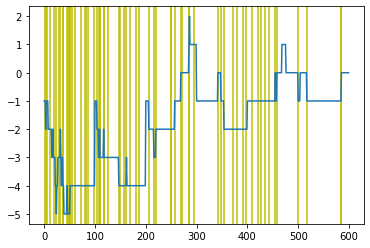

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=6, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_20(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_21(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 187, 32)           128       
_________________________________________________________________
flatten_13 (Flatten)         (None, 5984)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 19)                113715    
Total params: 113,843
Trainable params: 113,843
Non-trainable params: 0
_________________________________________________________________
 |████████████████████--------------------------------------------------------------------------------| 20.0% 
Taking action 1

Step 1 reward=-2 new_state=[1 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [ 1.13929898e-01  1.24528576e-02 -1.16965346e-

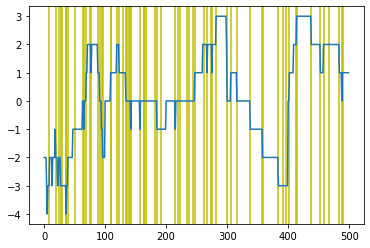

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=5, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_21(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 187, 32)           128       
_________________________________________________________________
flatten_14 (Flatten)         (None, 5984)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 19)                113715    
Total params: 113,843
Trainable params: 113,843
Non-trainable params: 0
_________________________________________________________________
PERFORMING RANDOM ACTION

Taking action 9

Step 1 reward=-2 new_state=[0 0 0 0 1 0 0 0 0]
Predicted scores for each action in next step: [ 0.06353027  0.11294562  0.08529295 -0.0272862   0.01068775 -0.10373767
  0.00607626  0.12164999  0.04722446 -0.02234321  0.032874

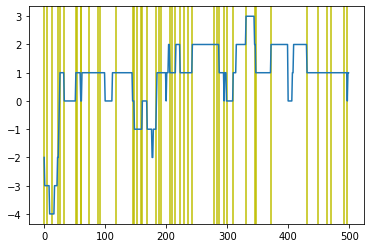

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=5, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_21(env), epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_22(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 187, 64)           256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 11968)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 19)                227411    
Total params: 227,667
Trainable params: 227,667
Non-trainable params: 0
_________________________________________________________________
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 
Taking action 15

Step 1 reward=0 new_state=[0 0 0 0 0 0 0 1 0]
Predicted scores for each action in next step: [ 0.02137801  0.02758127  0.01183015 -0.182080

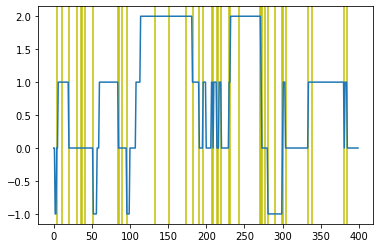

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=4, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_22(env), epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 187, 32)           128       
_________________________________________________________________
flatten_4 (Flatten)          (None, 5984)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 19)                113715    
Total params: 113,843
Trainable params: 113,843
Non-trainable params: 0
_________________________________________________________________
 |████████████----------------------------------------------------------------------------------------| 12.5% 
Taking action 6

Step 1 reward=-1 new_state=[0 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [ 0.04379103 -0.11789246  0.08814161 -0.055872

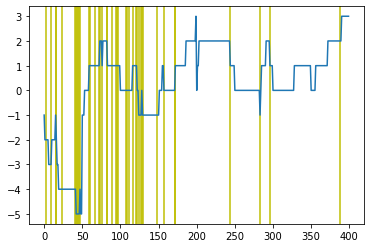

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=8, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_21(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_24(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(8, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 187, 8)            32        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1496)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 19)                28443     
Total params: 28,475
Trainable params: 28,475
Non-trainable params: 0
_________________________________________________________________
 |████████████----------------------------------------------------------------------------------------| 12.5% 
Taking action 6

Step 1 reward=-1 new_state=[0 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [ 0.08598629 -0.08291756  0.3093452  -0.13864309

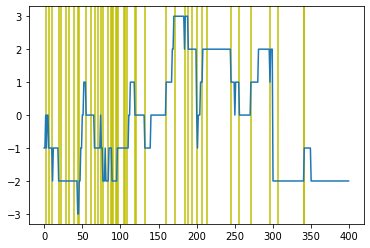

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=8, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_24(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_25(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(8, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(env.action_space.n))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.summary()
    return model

W0826 09:12:52.056147 140404775921536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 187, 8)            32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 8)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 744)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                14155     
Total params: 14,187
Trainable params: 14,187
Non-trainable params: 0
_________________________________________________________________
 |████████████----------------------------------------------------------------------------------------| 12.5% 
Taking action 1 from 1

Ste

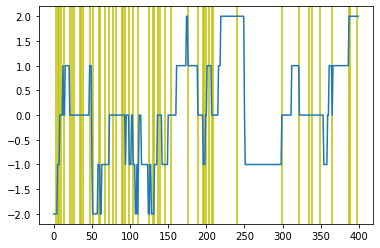

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=8, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_25(env), max_epsilon=0.15, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_26(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(3, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(env.action_space.n, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.01))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 187, 3)            12        
_________________________________________________________________
flatten_12 (Flatten)         (None, 561)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 19)                10678     
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________
 |████████████----------------------------------------------------------------------------------------| 12.5% 
Taking action 6 from 6

Step 1 reward=-1 new_state=[0 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [ 0.02773669 -0.497844    0.3137277  -0.0

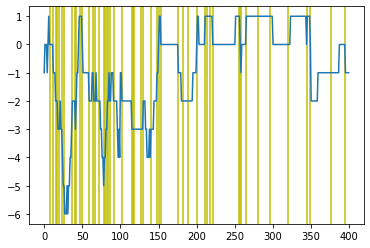

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=8, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_26(env), max_epsilon=0.2, epsilon_decay=0.8)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 189, 1)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 187, 3)            12        
_________________________________________________________________
flatten_13 (Flatten)         (None, 561)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 19)                10678     
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________
 |██████----------------------------------------------------------------------------------------------| 6.2% 
Taking action 1 from 1

Step 1 reward=-2 new_state=[1 0 0 0 0 0 0 0 0]
Predicted scores for each action in next step: [-0.5516665   0.5373595   0.20347917  0.42

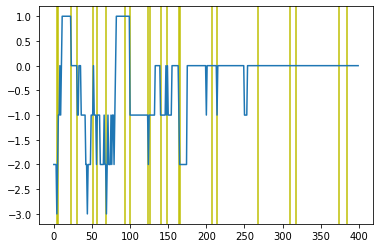

In [ ]:
env = GemelEnv(interval=10, max_steps=25, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=16, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_26(env), max_epsilon=0.1, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

W0827 07:48:33.117767 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 07:48:33.134547 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 07:48:33.146409 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 07:48:33.196032 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 187, 3)            12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 561)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                10678     
Total params: 10,690
Trainable params: 10,690
Non-trainable params: 0
_________________________________________________________________


W0827 07:48:45.049633 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0827 07:48:45.052090 140127216002944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.




Taking action 11 from 15

Step 1 reward=0 new_state=[0 0 0 0 0 1 0 0 0]
Predicted scores for each action in next step: [-0.10309277  0.5984335   0.2602821   0.2871314   0.23329741 -0.30147278
 -0.10267039 -0.6985116  -0.87149316  0.15684015 -0.10640725  0.5068413
  0.56695336  0.3792713  -0.56987524 -0.34771022 -0.3119429  -0.27110922
  0.7924583 ]

Taking action 18 from 18

Step 2 reward=0 new_state=[0 0 0 0 0 1 0 0 0]
Predicted scores for each action in next step: [-0.02578343 -0.19632375  0.02845808  0.05576573  0.3348491  -0.42152908
  0.22095078  0.15249772 -0.88207215  0.14279985 -0.24246047  0.39012823
  0.2450839   0.06260139 -0.51347774  1.1625648   0.34878966 -0.3526837
  0.38910627]

Taking action 11 from 15

Step 3 reward=0 new_state=[0 0 0 0 0 1 0 0 0]
Predicted scores for each action in next step: [-0.02284673  0.07801144  0.52321166  0.35037735  0.59441    -0.24195401
  0.11019468  0.0686993  -0.58738154  0.5661438  -0.21393275  0.41433498
  0.58088833  0.44216388 -0.57

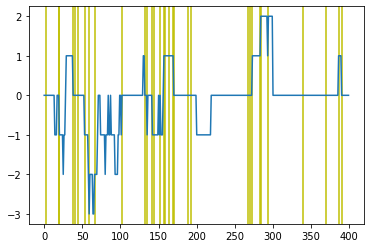

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=8, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_26(env), max_epsilon=0.1, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 -0.15976723 -0.11257976  0.09704254 -0.1426222  -0.20286576 -0.02509947
 -0.09681693 -0.09237857 -0.09958698 -0.05768096 -0.0555824   1.4847052
 -0.04898446]

Taking action 11 from 17

Step 83 reward=0 new_state=[0 0 0 0 1 1 0 1 0]
Predicted scores for each action in next step: [-0.09974854 -0.26154268 -0.03680118 -0.07103981  0.20459686 -0.08601997
 -0.15976723 -0.11257976  0.09711615 -0.14155217 -0.20286576 -0.02509653
 -0.09681693 -0.09237857 -0.09958698 -0.05768096 -0.0555824   1.4861475
 -0.03931977]

Taking action 11 from 17

Step 84 reward=0 new_state=[0 0 0 0 1 1 0 1 0]
Predicted scores for each action in next step: [-0.09834614 -0.26154268 -0.03679752 -0.07103981  0.20912416 -0.08601997
 -0.15976723 -0.11257976  0.0971825  -0.14058761 -0.20286576 -0.02509387
 -0.09681693 -0.09237857 -0.09958698 -0.05768096 -0.0555824   1.4866655
 -0.03060786]

Taking action 11 from 17

Step 85 reward=0 new_state=[0 

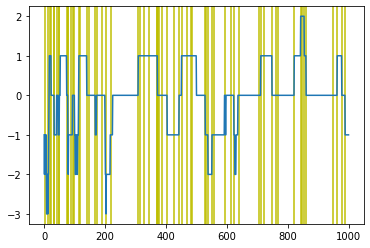

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=10, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_26(env), max_epsilon=0.1, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

In [ ]:
def model_conv_27(env):
    input_shape = env.observation_shape()
    model = Sequential()
    model.add(Reshape(input_shape + (1, ), input_shape=input_shape))
    model.add(Conv1D(16, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(24))
    model.add(Dense(env.action_space.n, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(lr=0.01))
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 187, 16)           64        
_________________________________________________________________
flatten_8 (Flatten)          (None, 2992)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                71832     
_________________________________________________________________
dense_13 (Dense)             (None, 19)                475       
Total params: 72,371
Trainable params: 72,371
Non-trainable params: 0
_________________________________________________________________
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 
Taking action 1 from 1

Ste

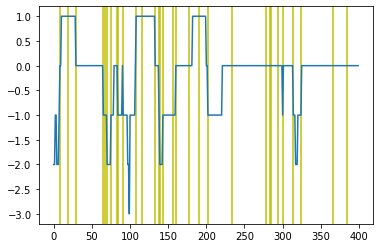

In [ ]:
env = GemelEnv(interval=10, max_steps=100, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=4, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_27(env), max_epsilon=0.1, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 189, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 187, 16)           64        
_________________________________________________________________
flatten_9 (Flatten)          (None, 2992)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                71832     
_________________________________________________________________
dense_15 (Dense)             (None, 19)                475       
Total params: 72,371
Trainable params: 72,371
Non-trainable params: 0
_________________________________________________________________
 |██████████------------------------------------------------------------------------------------------| 10.0% 
Taking action 0 from 0

Ste

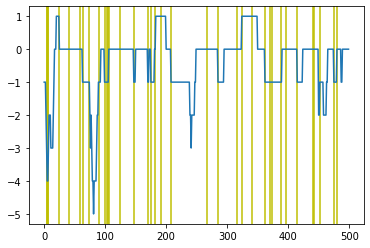

In [ ]:
env = GemelEnv(interval=10, max_steps=50, actions=GemelEnv.ActionSpace.DOUBLE_BUTTON)
env.reset()
agent = DQNAgent(env, max_eps=10, period=5, state_mode=DQNAgent.StateModel.IDS, gamma=0.8, model=model_conv_27(env), max_epsilon=0.1, epsilon_decay=0.9)
hist = agent.train()
flat_hist = [x for h in hist for x in h]
ticks = [idx for idx, x in enumerate(flat_hist) if x["random"]]
for xc in ticks: plt.axvline(x=xc, color='y')
plt.plot([x['reward'] for x in flat_hist])
agent.test()